<a href="https://colab.research.google.com/github/michael-0907/tibami/blob/main/bank_EDA_ETL_Data_Leakage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📦 ETL（Extract - Transform - Load，擷取、轉換、載入）

## ETL 是資料處理流程中的三個步驟：

### 🔹 Extract（擷取）
從資料庫、CSV、API 等來源取得資料。

### 🔹 Transform（轉換）
清洗與格式化資料，例如欄位轉換、補缺值、編碼等。

### 🔹 Load（載入）
將處理後的資料儲存至資料庫或檔案，供後續分析或使用。

---

# 📊 EDA（Exploratory Data Analysis，探索性資料分析）

## EDA 的目的是理解資料內容與結構，找出潛在問題與特徵，為建模做準備。

### 常見步驟包括：
- 查看資料結構（`df.head()`, `df.info()`, `df.describe()`）
- 檢查缺失值與異常值
- 類別與數值欄位的分布分析
- 欄位間的關聯（相關係數、群組分析）
- 資料視覺化（長條圖、直方圖、箱型圖等）

---

# ✅ 總結

- **ETL** 是【準備資料】的流程，讓資料乾淨且格式統一，便於分析與建模。
- **EDA** 是【探索與分析資料】的過程，用來發掘資料背後的結構、趨勢與問題。
- 在實務上，兩者常常穿插進行，例如在 EDA 中發現問題後再回頭修改 ETL 流程。


# ❗ 關於 `duration` 的資料洩露問題

在處理如銀行行銷資料（如 UCI Bank Marketing Dataset）時，`duration` 欄位常會導致資料洩露。

---

## 📌 資料洩露是什麼？

**資料洩露（Data Leakage）** 指的是模型在訓練時，使用到了未來才會知道的資訊，導致模型表現看似很好，但實際上無法泛化到真實資料。

---

## 🔍 `duration` 為何會洩露？

- `duration` 表示一次通話的長度（單位：秒）
- 該欄位是在「通話結束後」才會知道
- 但我們模型的任務是預測「通話前」是否客戶會訂閱定存

✅ 因此，`duration` 是一個**事後才知道的資訊**，若納入模型就會構成洩露。

---

## 🔎 面對洩露，你可以怎麼做？

| 處理方式                              | 是否建議 | 說明 |
|---------------------------------------|----------|------|
| **整個刪除 `duration` 欄位**           | ✅ 建議  | 最正確、最保險的作法，避免洩漏。 |
| **只刪除 `duration == 0` 的資料列**   | ❌ 不建議 | 僅處理特殊值，無法解決洩漏本質。 |
| **同時刪欄位與刪除 `duration == 0` 行** | ❌ 過度處理 | 刪除欄位已足夠，不需額外刪行。 |

---

## ✅ 結論

> **為避免洩露，應完全從特徵中移除 `duration` 欄位，不納入模型訓練。**



In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
data = pd.read_csv("/content/sample_data/bank-full.csv", encoding="utf-8", sep=";")
display(data.shape)
display(data.head(3))

(45211, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [72]:
data["duration"].describe()

,duration
count,45211.000000
mean,258.163080
std,257.527812
min,0.000000
25%,103.000000
50%,180.000000
75%,319.000000
max,4918.000000


In [73]:
data[data["duration"] == 0].shape

(3, 17)

In [74]:
df = data.copy()

# 刪除有疑慮的欄位
df = data.drop(columns=["month", "day"])

# 刪除有unknown的行
df = df[~df.isin(["unknown"]).any(axis=1)]

df.shape


(7842, 15)

In [75]:
df["y"] = df["y"].map({"yes": 1, "no": 0})


In [76]:
# 將balance < 0 的刪除
# balance < 0  的刪除後， padys=-1 的就沒了，pdays的最小值變成 1
df = df[df["balance"] >= 0 ]
df.shape


(7371, 15)

In [77]:
for col in df.columns:
  unknown_col = df[col].isin(["unknown"])
  if unknown_col.any():
    print(f"含有unknown的特徵: {col}, 數量: {unknown_col.sum()}")
unknown_row = df.isin(["unknown"]).any(axis=1)
print(f"總行數: {df.shape[0]}")
print(f"含有unknown的行數: {unknown_row.sum()}")


總行數: 7371
含有unknown的行數: 0


In [78]:
column_info = []
for col in df.columns:
  info_dtype = df[col].dtype
  info_isna = df[col].isna().any()
  info_nunique = df[col].nunique()
  info_min = df[col].min()
  info_max = df[col].max()
  info_unique_20 = df[col].unique()[0: 20]

  c = [col, info_dtype, info_isna, info_nunique, info_min, info_max, info_unique_20]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "min", "max", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(column_info_df)

# column_info_df.to_csv("column_info_bank.csv")


,col_name,dtype,isna,unique_num,min,max,unique_20
0,age,int64,False,70,18,89,"[33, 36, 44, 26, 51, 30, 34, 49, 47, 40, 38, 5..."
1,job,object,False,11,admin.,unemployed,"[admin., services, management, blue-collar, te..."
2,marital,object,False,3,divorced,single,"[married, single, divorced]"
3,education,object,False,3,primary,tertiary,"[tertiary, secondary, primary]"
4,default,object,False,2,no,yes,"[no, yes]"
5,balance,int64,False,2764,0,81204,"[882, 3444, 2415, 0, 1324, 172, 3132, 1005, 87..."
6,housing,object,False,2,no,yes,"[no, yes]"
7,loan,object,False,2,no,yes,"[no, yes]"
8,contact,object,False,2,cellular,telephone,"[telephone, cellular]"
9,duration,int64,False,957,5,2219,"[39, 144, 73, 140, 119, 21, 449, 175, 86, 81, ..."


In [79]:
display(df.dtypes.value_counts())
display(df.select_dtypes(include=["object"]).columns)
display(df.select_dtypes(include=["int64"]).columns)

,count
object,8
int64,7


Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'poutcome'],
      dtype='object')

Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y'], dtype='object')

In [80]:
df[int_columns].describe()

,age,balance,duration,campaign,pdays,previous
count,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000,7371.000000
mean,40.866233,1670.076516,262.092118,2.051689,219.808981,3.184371
std,11.429900,3144.433686,236.519785,1.557026,112.065792,4.680170
min,18.000000,0.000000,5.000000,1.000000,1.000000,1.000000
25%,32.000000,226.000000,114.000000,1.000000,127.000000,1.000000
50%,38.000000,674.000000,195.000000,2.000000,190.000000,2.000000
75%,48.000000,1852.500000,325.000000,2.000000,322.000000,4.000000
max,89.000000,81204.000000,2219.000000,16.000000,871.000000,275.000000


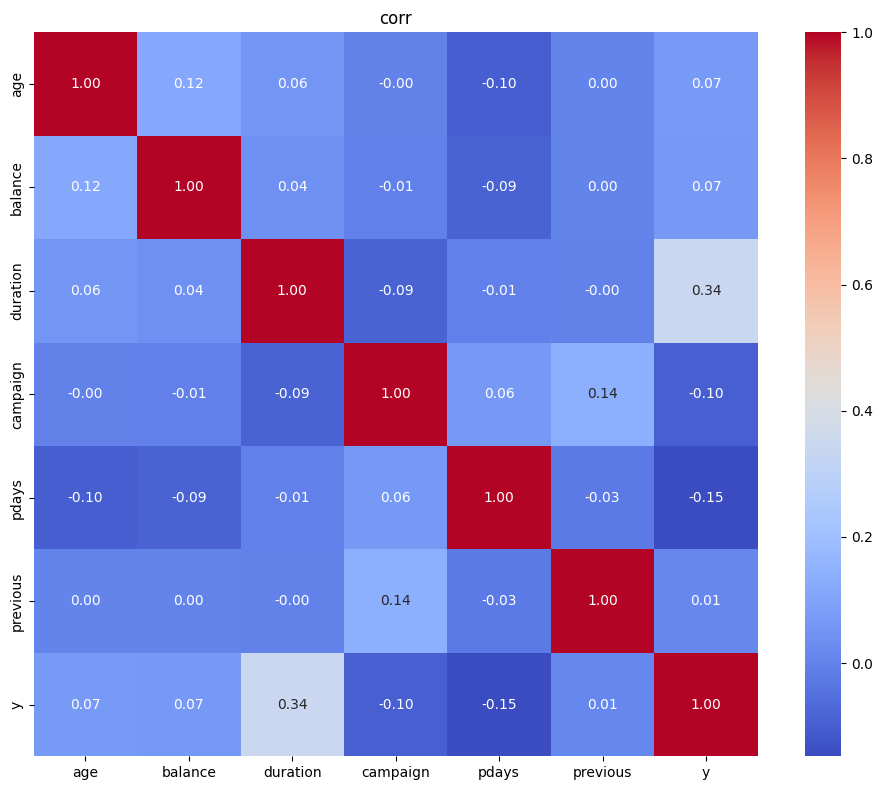

In [81]:
int_columns_y = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'y']

corr = df[int_columns_y].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("corr")
plt.tight_layout()
plt.show()

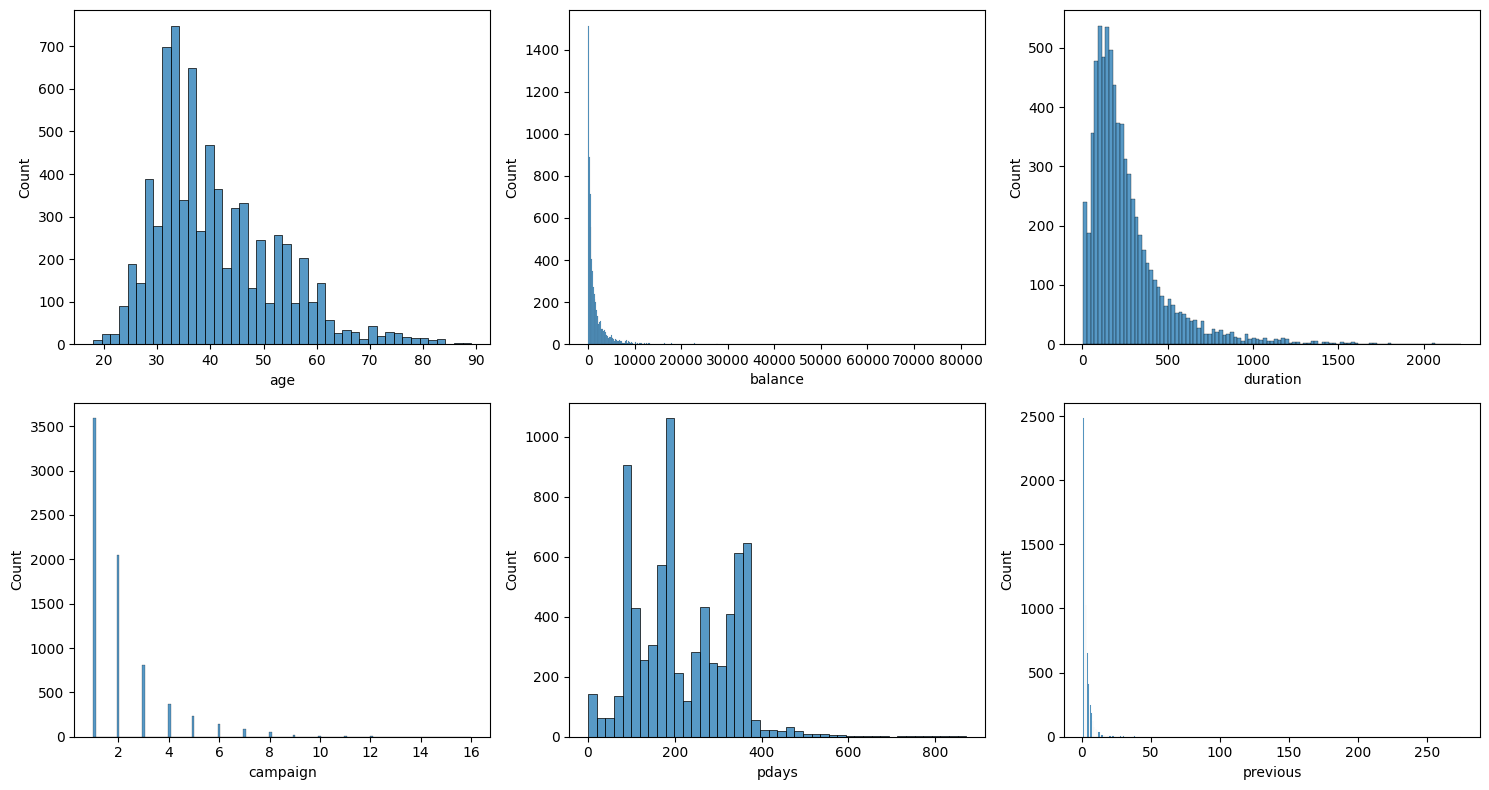

In [83]:

int_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(int_columns):
  sns.histplot(data=df, x=df[col], ax=axes[i])
plt.tight_layout()



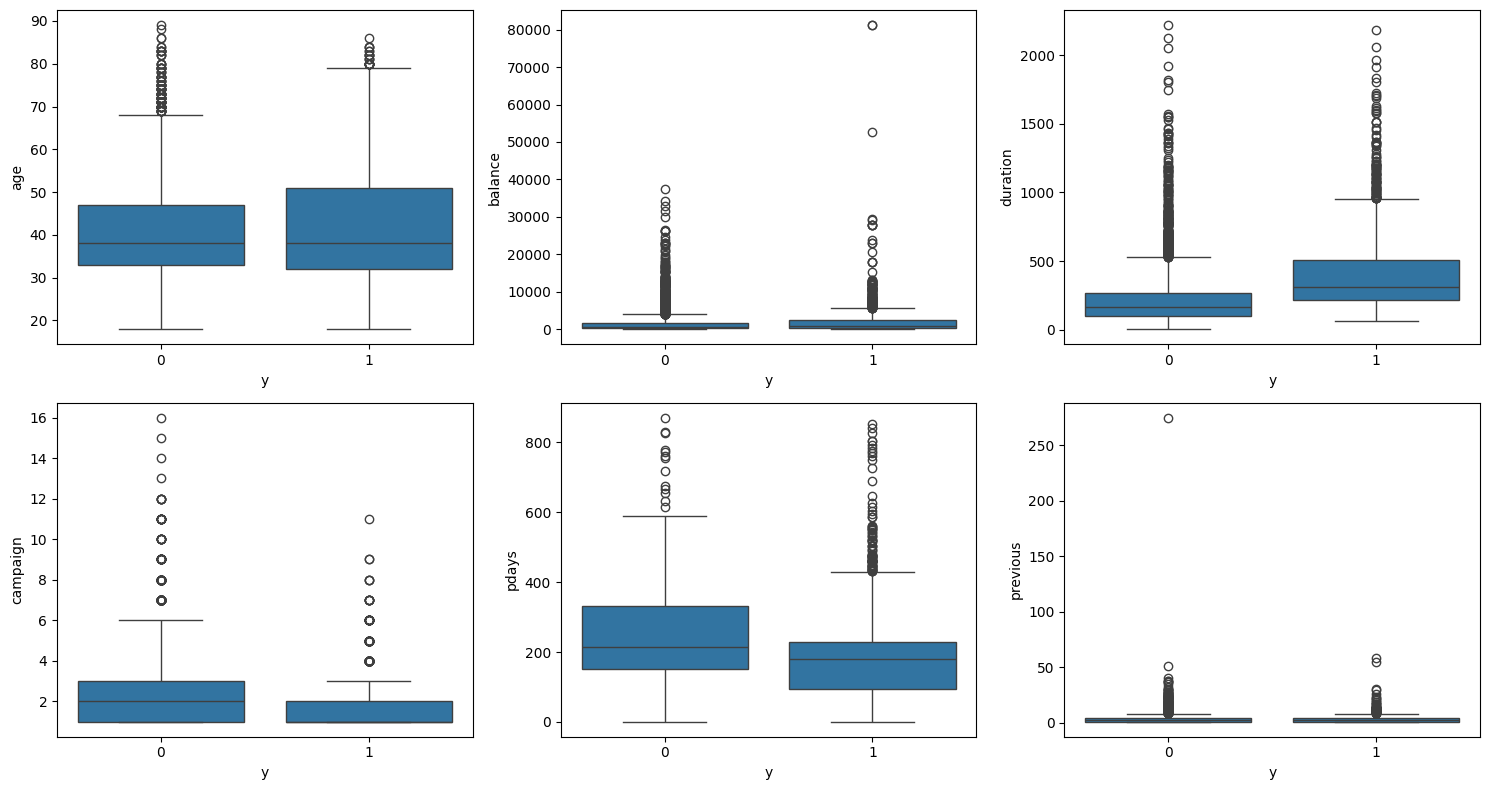

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(int_columns):
  sns.boxplot(data=df, x=df["y"], y=df[col], ax=axes[i])
plt.tight_layout()


'\ny 軸呈現明顯上升趨勢，顯示 duration 越高，target=1（訂閱） 的比例越高\n趨勢非常清楚 → 資料洩漏風險也更明顯\n這樣的上升曲線幾乎可以說明：\n通話時間越長，越可能成功訂閱\n但問題是：這個時間是「事後才知道」的 → 所以不能用在預測！\n'

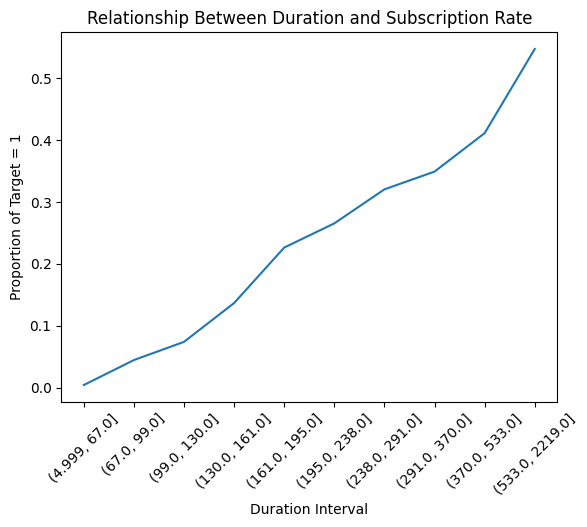

In [85]:
# 分析並視覺化「通話時間（duration）」與「訂閱率（目標變數 y=1 的比例）」之間的關係

# 建立 duration 分箱
df["duration_bin"] = pd.qcut(df["duration"], q=10)  # 用 qcut 等數量分箱，處理偏態/離群值的好方式，讓每個區間統計更穩定

# 計算每個 bin 中 target = 1 的比例，因為值只有 0 和 1，平均值就是「有訂閱的比例」
grouped = df.groupby("duration_bin", observed=True)["y"].mean().reset_index()

# 畫圖
sns.lineplot(x=grouped["duration_bin"].astype(str), y=grouped["y"])
plt.xticks(rotation=45)

plt.ylabel("Proportion of Target = 1") # 目標變數 = 1 的比例
plt.xlabel("Duration Interval") # duration 區間
plt.title("Relationship Between Duration and Subscription Rate") # duration 與訂閱機率的關係

"""
y 軸呈現明顯上升趨勢，顯示 duration 越高，target=1（訂閱） 的比例越高
趨勢非常清楚 → 資料洩漏風險也更明顯
這樣的上升曲線幾乎可以說明：
通話時間越長，越可能成功訂閱
但問題是：這個時間是「事後才知道」的 → 所以不能用在預測！
"""

In [86]:
# 新欄位 duration_bin 是類別型（category），代表每筆資料落在哪個區間
df["duration_bin"].value_counts()

,count
duration_bin,
"(130.0, 161.0]",761
"(67.0, 99.0]",743
"(195.0, 238.0]",742
"(4.999, 67.0]",741
"(533.0, 2219.0]",736
"(370.0, 533.0]",734
"(291.0, 370.0]",733
"(99.0, 130.0]",731
"(238.0, 291.0]",730


In [88]:
grouped

,duration_bin,y
0,"(4.999, 67.0]",0.004049
1,"(67.0, 99.0]",0.044415
2,"(99.0, 130.0]",0.073871
3,"(130.0, 161.0]",0.136662
4,"(161.0, 195.0]",0.226389
5,"(195.0, 238.0]",0.265499
6,"(238.0, 291.0]",0.320548
7,"(291.0, 370.0]",0.349250
8,"(370.0, 533.0]",0.411444
9,"(533.0, 2219.0]",0.547554


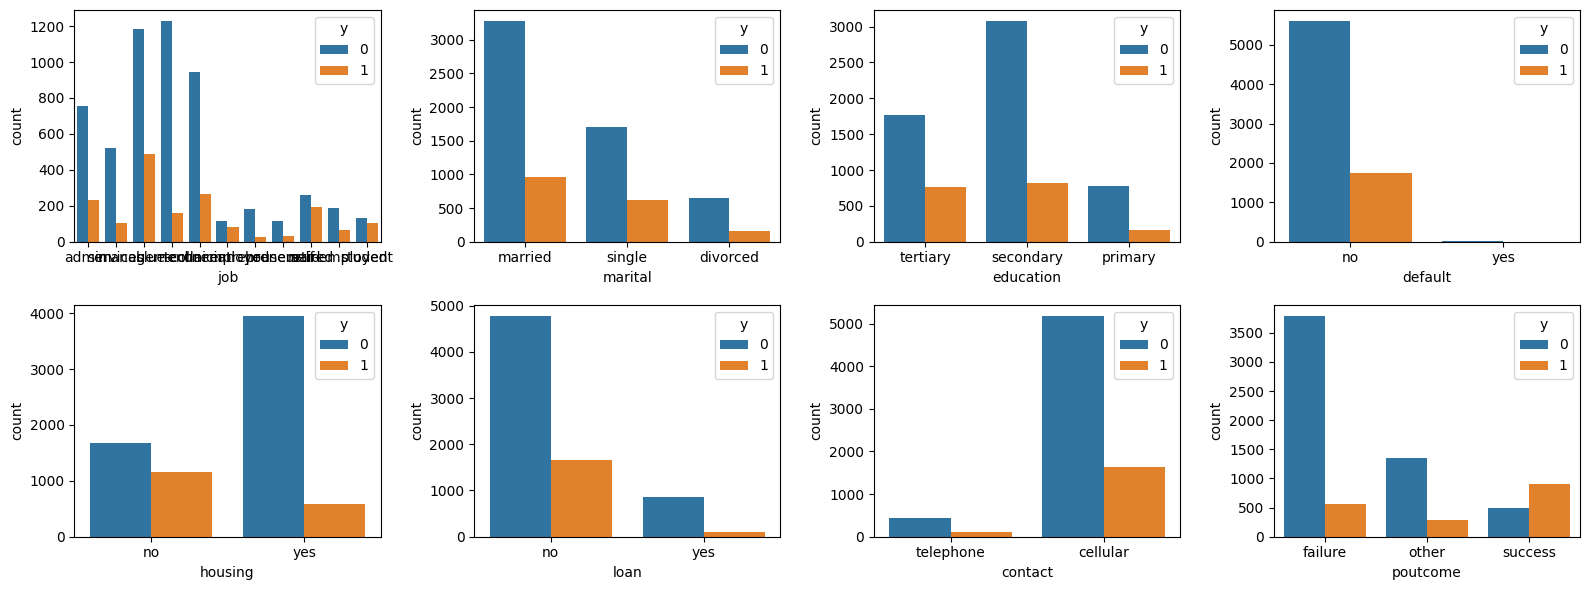

In [87]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

fig, axes = plt.subplots(2, 4, figsize=(16, 6))
axes = axes.flatten()

for i, col in enumerate(cat_columns):
  sns.countplot(data=df, x=df[col], ax=axes[i], hue=df["y"])
plt.tight_layout()
